In [6]:
'''Import all the necessary packages'''

from scipy import signal
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader,Dataset
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
import torchvision.transforms as transforms
transf = transforms.ToTensor()
import requests
import matplotlib.pyplot as plt
from scipy.fft import fftfreq, fft
from scipy.signal import butter, lfilter
from scipy.io import loadmat
from pathlib import Path

In [1]:
'''Change the file reading code correspondingly to your directories.
This is an example of working on Google Drive'''

from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive'  # Assuming the file is directly under MyDrive

import sys
sys.path.append(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
class All_Config:
    lr = 1e-4
    batch_size = 32,
    num_subjects = 9,
    base_data_path='/content/drive/MyDrive',
    base_target_path='/content/drive/MyDrive',
    data_file_pattern='MI-EEG-A0{}',  # {} will be replaced by subject number
    target_file_pattern='EtiquetasA0{}',
    n_timesteps = 1000,
    n_features = 22,
    n_outputs = 4,
    All_Models = ["LSTM", "CNN1D", "CNN2D", "CNNLSTM", "CNNGRU", "EEGNet", "EEGAttention", "EEGNex"]

def Model_evaluation(model_names):
    from data_preprocessing import make_dataset
    try:
        # Check if the model is in the list
        if set(model_names).issubset(set(All_Config.All_Models)):
            print("models are in the list.")
            # If model is not found in the list, raise an exception
        else:
            raise ValueError("Error: at least one model is not found in the list of models.")
    except ValueError as e:
        # Handle the exception by printing an error message
        print(e)

    # We store all final results in this list
    Results = []
    for i in range(1, All_Config.num_subjects[0]+1):
        val_dataloader, train_dataloader = make_dataset(
            num_subjects=All_Config.num_subjects[0],
            subject = i,
            base_data_path=All_Config.base_data_path[0],
            base_target_path=All_Config.base_target_path[0],
            data_file_pattern=All_Config.data_file_pattern[0],  # {} will be replaced by subject number
            target_file_pattern=All_Config.target_file_pattern[0],
            batch_size = All_Config.batch_size[0]
        )

        '''Now iteratively define the model, train and test'''
        # Load the model
        for model_name in model_names:
            if model_name == "LSTM":
                from Models import SingleLSTM
                model = SingleLSTM(n_features = All_Config.n_features[0], n_outputs = All_Config.n_outputs[0])
                Model = "LSTM"
            if model_name == "CNN1D":
                from Models import OneD_CNN
                model = OneD_CNN(n_timesteps = All_Config.n_timesteps[0], n_features = All_Config.n_features[0], n_outputs = All_Config.n_outputs[0])
                Model = "CNN1D"
            if model_name == "CNN2D":
                from Models import TwoD_CNN
                model = TwoD_CNN(n_timesteps = All_Config.n_timesteps[0], n_features = All_Config.n_features[0], n_outputs = All_Config.n_outputs[0])
                Model = "CNN2D"
            if model_name == "CNNLSTM":
                from Models import CNN_LSTM
                model = CNN_LSTM(n_timesteps = All_Config.n_timesteps[0], n_features = All_Config.n_features[0], n_outputs = All_Config.n_outputs[0])
                Model = "CNNLSTM"
            if model_name == "CcNGRU":
                from Models import CNN_GRU
                model = CNN_GRU(n_timesteps = All_Config.n_timesteps[0], n_features = All_Config.n_features[0], n_outputs = All_Config.n_outputs[0])
                Model = "CNNGRU"
            if model_name == "EEGNet":
                from Models import EEGNet_8_2
                model = EEGNet_8_2(n_timesteps = All_Config.n_timesteps[0], n_features = All_Config.n_features[0], n_outputs = All_Config.n_outputs[0])
                Model = "CNN2D"
            if model_name == "EEGAttention":
                from Models import EEGNet_8_2_att
                model = EEGNet_8_2_att(n_timesteps = All_Config.n_timesteps[0], n_features = All_Config.n_features[0], n_outputs = All_Config.n_outputs[0])
                Model = "CNN2D"
            if model_name == "EEGNex":
                from Models import EEGNeX_8_32
                model = EEGNeX_8_32(n_timesteps = All_Config.n_timesteps[0], n_features = All_Config.n_features[0], n_outputs = All_Config.n_outputs[0])
                Model = "CNN2D"

            # Train the model

            import copy
            from torch import optim

            criterion = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr = All_Config.lr)
            # Training process
            n_epochs = 100  # Number of epochs
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            model = model.to(device)
            best_model_wts = copy.deepcopy(model.state_dict())
            best_loss = np.inf
            patience = 10
            early_stopping_counter = 0
            for epoch in range(n_epochs):
                model.train()  # Set the model to training mode
                running_loss = 0.0

                for i, (inputs, labels) in enumerate(train_dataloader):
                    # Move data to GPU
                    if Model == "CNN2D":
                        inputs=inputs.unsqueeze(1)
                    else:
                        inputs = inputs.permute(0, 2, 1)
                    inputs, labels = inputs.to(device), labels.to(device)
                    # Forward pass
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    running_loss += loss.item()
                    # Backward and optimize
                    optimizer.zero_grad()  # Zero the gradient buffers
                    loss.backward()  # Backpropagation
                    optimizer.step()  # Update the weights
                epoch_loss = running_loss / len(train_dataloader)
                model.eval()
                val_loss = 0.0
                with torch.no_grad():
                    for inputs, labels in val_dataloader:
                        if Model == "CNN2D":
                            inputs=inputs.unsqueeze(1)
                        else:
                            inputs = inputs.permute(0, 2, 1)
                        inputs = inputs.to(device)
                        labels = labels.to(device)
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        val_loss += loss.item()
                val_loss /= len(val_dataloader)

                #if n_epochs % 10 == 0:
                print(f'Epoch [{epoch + 1}/{n_epochs}], Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}')
                # Early stopping
                if val_loss < best_loss:
                    best_loss = val_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    early_stopping_counter = 0
                else:
                    early_stopping_counter += 1
                    if early_stopping_counter >= patience:
                        print("Early stopping")
                        break
            print('Finished Training')
            # Load the best model weights
            model.load_state_dict(best_model_wts)

            # The evaluation scheme
            model.eval()  # Ensure the model is in evaluation mode

            result = np.zeros((All_Config.n_outputs[0],All_Config.n_outputs[0]))
            with torch.no_grad():
                for inputs, labels in val_dataloader:  # Here val_dataloader is used for testing
                    if Model == "CNN2D":
                        inputs=inputs.unsqueeze(1)
                    else:
                        inputs = inputs.permute(0, 2, 1)
                    _, labels_indices = torch.max(labels, dim=1)
                    inputs = inputs.to(device)
                    labels_indices = labels_indices.to(device)

                    outputs = model(inputs)
                    _, predicted = torch.max(outputs, 1)
                    # Update the total count of predictions and the number of correct predictions
                    for label, prediction in zip(labels_indices, predicted):
                        result[label-1][prediction-1] += 1
            Results.append(result)
            print(result)
    return Results

In [5]:
list_arrays = Model_evaluation(["LSTM", "CNN1D", "CNN2D", "CNNLSTM", "CNNGRU", "EEGNet", "EEGAttention", "EEGNex"])

models are in the list.
1 is a valid integer between 1 and 9
Epoch [1/100], Training Loss: 1.3870, Validation Loss: 1.3864
Epoch [2/100], Training Loss: 1.3863, Validation Loss: 1.3864
Epoch [3/100], Training Loss: 1.3861, Validation Loss: 1.3864
Epoch [4/100], Training Loss: 1.3852, Validation Loss: 1.3866
Epoch [5/100], Training Loss: 1.3840, Validation Loss: 1.3857
Epoch [6/100], Training Loss: 1.3800, Validation Loss: 1.3818
Epoch [7/100], Training Loss: 1.3759, Validation Loss: 1.3786
Epoch [8/100], Training Loss: 1.3729, Validation Loss: 1.3772
Epoch [9/100], Training Loss: 1.3711, Validation Loss: 1.3747
Epoch [10/100], Training Loss: 1.3689, Validation Loss: 1.3757
Epoch [11/100], Training Loss: 1.3651, Validation Loss: 1.3756
Epoch [12/100], Training Loss: 1.3643, Validation Loss: 1.3720
Epoch [13/100], Training Loss: 1.3625, Validation Loss: 1.3732
Epoch [14/100], Training Loss: 1.3594, Validation Loss: 1.3662
Epoch [15/100], Training Loss: 1.3576, Validation Loss: 1.3589
Epo

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1040.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch [1/100], Training Loss: 1.4060, Validation Loss: 1.3527
Epoch [2/100], Training Loss: 1.3896, Validation Loss: 1.3307
Epoch [3/100], Training Loss: 1.3757, Validation Loss: 1.3038
Epoch [4/100], Training Loss: 1.3529, Validation Loss: 1.2719
Epoch [5/100], Training Loss: 1.3444, Validation Loss: 1.2316
Epoch [6/100], Training Loss: 1.3217, Validation Loss: 1.1868
Epoch [7/100], Training Loss: 1.3061, Validation Loss: 1.1435
Epoch [8/100], Training Loss: 1.2970, Validation Loss: 1.0979
Epoch [9/100], Training Loss: 1.2863, Validation Loss: 1.0695
Epoch [10/100], Training Loss: 1.2689, Validation Loss: 1.0417
Epoch [11/100], Training Loss: 1.2497, Validation Loss: 1.0170
Epoch [12/100], Training Loss: 1.2421, Validation Loss: 0.9962
Epoch [13/100], Training Loss: 1.2331, Validation Loss: 0.9723
Epoch [14/100], Training Loss: 1.2258, Validation Loss: 0.9448
Epoch [15/100], Training Loss: 1.2079, Validation Loss: 0.9310
Epoch [16/100], Training Loss: 1.1947, Validation Loss: 0.9188
E

[array([[29., 10., 12., 93.],
        [12., 20., 55., 57.],
        [12., 11., 81., 40.],
        [19.,  8., 19., 98.]]),
 array([[ 73.,  13.,   0.,  58.],
        [ 14.,  99.,  20.,  11.],
        [  5.,  84.,  47.,   8.],
        [ 17.,  24.,   2., 101.]]),
 array([[ 62.,  16.,   5.,  61.],
        [ 11.,  62.,  56.,  15.],
        [  3.,  37.,  94.,  10.],
        [ 18.,   9.,   8., 109.]]),
 array([[ 80.,   4.,   1.,  59.],
        [ 17.,  50.,  63.,  14.],
        [  1.,  34., 101.,   8.],
        [ 10.,  13.,   2., 119.]]),
 array([[ 79.,   4.,   1.,  60.],
        [ 13.,  56.,  63.,  12.],
        [  3.,  38., 100.,   3.],
        [ 13.,  10.,   5., 116.]]),
 array([[ 67.,   0.,   0.,  77.],
        [ 10.,  26.,  80.,  28.],
        [  0.,  13., 118.,  13.],
        [  9.,   0.,   0., 135.]]),
 array([[ 22.,   0.,   3., 119.],
        [ 42.,  30.,  27.,  45.],
        [ 23.,  46.,  61.,  14.],
        [ 23.,   8.,   3., 110.]]),
 array([[114.,   0.,   2.,  28.],
        [ 15.,  

I include the results I get here. It's also stored in the repository.

In [3]:
list_arrays = [np.array([[29., 10., 12., 93.],
        [12., 20., 55., 57.],
        [12., 11., 81., 40.],
        [19.,  8., 19., 98.]]),
 np.array([[ 73.,  13.,   0.,  58.],
        [ 14.,  99.,  20.,  11.],
        [  5.,  84.,  47.,   8.],
        [ 17.,  24.,   2., 101.]]),
 np.array([[ 62.,  16.,   5.,  61.],
        [ 11.,  62.,  56.,  15.],
        [  3.,  37.,  94.,  10.],
        [ 18.,   9.,   8., 109.]]),
 np.array([[ 80.,   4.,   1.,  59.],
        [ 17.,  50.,  63.,  14.],
        [  1.,  34., 101.,   8.],
        [ 10.,  13.,   2., 119.]]),
 np.array([[ 79.,   4.,   1.,  60.],
        [ 13.,  56.,  63.,  12.],
        [  3.,  38., 100.,   3.],
        [ 13.,  10.,   5., 116.]]),
 np.array([[ 67.,   0.,   0.,  77.],
        [ 10.,  26.,  80.,  28.],
        [  0.,  13., 118.,  13.],
        [  9.,   0.,   0., 135.]]),
 np.array([[ 22.,   0.,   3., 119.],
        [ 42.,  30.,  27.,  45.],
        [ 23.,  46.,  61.,  14.],
        [ 23.,   8.,   3., 110.]]),
 np.array([[114.,   0.,   2.,  28.],
        [ 15.,  27.,  87.,  15.],
        [  1.,  16., 125.,   2.],
        [ 15.,   2.,   6., 121.]]),
 np.array([[73., 22., 21., 28.],
        [57., 21., 37., 29.],
        [63., 11., 47., 23.],
        [66., 19., 24., 35.]]),
 np.array([[29., 18., 44., 53.],
        [31., 24., 69., 20.],
        [25., 20., 37., 62.],
        [31., 26., 26., 61.]]),
 np.array([[36., 25., 49., 34.],
        [16., 26., 77., 25.],
        [25., 17., 44., 58.],
        [21., 28., 37., 58.]]),
 np.array([[70., 13., 29., 32.],
        [53., 15., 51., 25.],
        [79., 15., 17., 33.],
        [61., 13., 27., 43.]]),
 np.array([[40., 43., 21., 40.],
        [20., 53., 46., 25.],
        [29., 37., 22., 56.],
        [32., 46., 22., 44.]]),
 np.array([[13., 70., 34., 27.],
        [12., 78., 32., 22.],
        [ 8., 85., 23., 28.],
        [ 8., 66., 38., 32.]]),
 np.array([[ 1.,  1., 69., 73.],
        [ 4.,  1., 68., 71.],
        [ 2.,  1., 68., 73.],
        [ 2.,  1., 74., 67.]]),
 np.array([[26., 15., 54., 49.],
        [28.,  7., 95., 14.],
        [36.,  5., 53., 50.],
        [20., 15., 57., 52.]]),
 np.array([[51.,  6., 20., 67.],
        [31., 16., 52., 45.],
        [ 9., 22., 86., 27.],
        [29., 10., 27., 78.]]),
 np.array([[ 60.,  22.,   8.,  54.],
        [ 27.,  57.,  24.,  36.],
        [  8.,  52.,  71.,  13.],
        [  6.,  13.,   4., 121.]]),
 np.array([[76., 20., 13., 35.],
        [39., 46., 34., 25.],
        [24., 41., 76.,  3.],
        [21., 16., 12., 95.]]),
 np.array([[ 68.,  14.,  26.,  36.],
        [ 21.,  41.,  65.,  17.],
        [  3.,  29., 110.,   2.],
        [  6.,  20.,  21.,  97.]]),
 np.array([[ 71.,  16.,  19.,  38.],
        [ 24.,  57.,  48.,  15.],
        [  2.,  36., 104.,   2.],
        [  7.,  27.,  13.,  97.]]),
 np.array([[118.,   1.,   7.,  18.],
        [ 21.,  48.,  40.,  35.],
        [  3.,  13., 123.,   5.],
        [  2.,   2.,   4., 136.]]),
 np.array([[47., 15., 11., 71.],
        [32., 29., 38., 45.],
        [18., 32., 85.,  9.],
        [25., 12., 15., 92.]]),
 np.array([[124.,   3.,   7.,  10.],
        [ 18.,  90.,  17.,  19.],
        [  4.,  26., 112.,   2.],
        [  3.,   6.,   8., 127.]]),
 np.array([[67., 26., 27., 24.],
        [62., 23., 42., 17.],
        [58., 25., 41., 20.],
        [66., 23., 26., 29.]]),
 np.array([[ 21.,  30.,  11.,  82.],
        [ 10.,  41.,  42.,  51.],
        [  6.,  44.,  46.,  48.],
        [  7.,  24.,   2., 111.]]),
 np.array([[50., 26., 19., 49.],
        [27., 26., 60., 31.],
        [19., 26., 65., 34.],
        [26., 21., 11., 86.]]),
 np.array([[48., 19., 24., 53.],
        [30., 13., 71., 30.],
        [29., 18., 76., 21.],
        [34., 11., 15., 84.]]),
 np.array([[51., 18., 24., 51.],
        [29., 15., 71., 29.],
        [26., 18., 79., 21.],
        [28., 11., 16., 89.]]),
 np.array([[ 52.,  42.,  11.,  39.],
        [ 10.,  31.,  54.,  49.],
        [  9.,  30.,  82.,  23.],
        [ 10.,  26.,   6., 102.]]),
 np.array([[  3.,  12.,   7., 122.],
        [  9.,  21.,  27.,  87.],
        [  9.,  18.,  23.,  94.],
        [  5.,   2.,   3., 134.]]),
 np.array([[69., 23., 19., 33.],
        [10., 20., 69., 45.],
        [15., 12., 97., 20.],
        [15., 24., 21., 84.]]),
 np.array([[19., 27., 41., 57.],
        [24., 24., 41., 55.],
        [14., 37., 42., 51.],
        [19., 31., 34., 60.]]),
 np.array([[43., 24., 27., 50.],
        [29., 31., 35., 49.],
        [33., 36., 32., 43.],
        [29., 25., 19., 71.]]),
 np.array([[55., 46., 26., 17.],
        [40., 53., 30., 21.],
        [35., 52., 36., 21.],
        [40., 41., 17., 46.]]),
 np.array([[50., 18., 47., 29.],
        [31., 27., 56., 30.],
        [39., 27., 51., 27.],
        [41., 28., 37., 38.]]),
 np.array([[57., 26., 31., 30.],
        [38., 23., 44., 39.],
        [37., 24., 49., 34.],
        [41., 20., 27., 56.]]),
 np.array([[39., 17., 31., 57.],
        [54., 14., 27., 49.],
        [47., 22., 39., 36.],
        [56., 13., 22., 53.]]),
 np.array([[  1.,   3.,  36., 104.],
        [  1.,   3.,  26., 114.],
        [  0.,   1.,  38., 105.],
        [  0.,   1.,  27., 116.]]),
 np.array([[72., 17., 11., 44.],
        [46., 34., 16., 48.],
        [58., 18., 32., 36.],
        [49., 18., 11., 66.]]),
 np.array([[60., 15., 46., 23.],
        [40., 15., 76., 13.],
        [53., 17., 59., 15.],
        [63., 16., 33., 32.]]),
 np.array([[26., 17., 51., 50.],
        [18., 20., 81., 25.],
        [17., 18., 70., 39.],
        [16., 16., 40., 72.]]),
 np.array([[31., 24., 28., 61.],
        [17., 40., 48., 39.],
        [19., 35., 32., 58.],
        [21., 17., 19., 87.]]),
 np.array([[21.,  8., 46., 69.],
        [14.,  7., 81., 42.],
        [12.,  8., 61., 63.],
        [11.,  4., 38., 91.]]),
 np.array([[16., 10., 53., 65.],
        [ 9.,  9., 82., 44.],
        [10.,  9., 67., 58.],
        [10.,  7., 33., 94.]]),
 np.array([[13., 21., 50., 60.],
        [ 6., 24., 82., 32.],
        [17., 13., 74., 40.],
        [15., 21., 37., 71.]]),
 np.array([[20., 16., 30., 78.],
        [23., 16., 50., 55.],
        [16., 18., 41., 69.],
        [14., 17., 28., 85.]]),
 np.array([[61., 19., 30., 34.],
        [32., 26., 57., 29.],
        [28., 26., 57., 33.],
        [17., 26., 26., 75.]]),
 np.array([[65., 12., 14., 53.],
        [55., 16., 22., 51.],
        [31., 14., 61., 38.],
        [63.,  8., 16., 57.]]),
 np.array([[70., 13., 14., 47.],
        [51., 17., 38., 38.],
        [24., 28., 80., 12.],
        [46., 10., 15., 73.]]),
 np.array([[46., 36., 13., 49.],
        [29., 35., 32., 48.],
        [15., 41., 71., 17.],
        [27., 30., 15., 72.]]),
 np.array([[64., 23., 21., 36.],
        [33., 37., 40., 34.],
        [17., 28., 88., 11.],
        [36., 23., 18., 67.]]),
 np.array([[75., 22., 14., 33.],
        [42., 47., 27., 28.],
        [26., 44., 66.,  8.],
        [48., 22., 11., 63.]]),
 np.array([[91., 11.,  1., 41.],
        [57., 31., 21., 35.],
        [10., 45., 79., 10.],
        [50.,  6.,  3., 85.]]),
 np.array([[82.,  3.,  3., 56.],
        [79.,  3.,  6., 56.],
        [82., 18., 14., 30.],
        [73.,  2.,  2., 67.]]),
 np.array([[ 62.,  22.,  29.,  31.],
        [ 41.,  42.,  25.,  36.],
        [  4.,  29., 107.,   4.],
        [ 30.,  16.,  24.,  74.]]),
 np.array([[ 9., 18., 36., 81.],
        [10., 20., 26., 88.],
        [ 6., 30., 62., 46.],
        [ 7., 23., 24., 90.]]),
 np.array([[107.,  11.,   8.,  18.],
        [ 45.,  32.,  13.,  54.],
        [ 26.,  40.,  68.,  10.],
        [ 15.,  10.,   2., 117.]]),
 np.array([[ 98.,  19.,  13.,  14.],
        [ 31.,  51.,  22.,  40.],
        [ 17.,  30.,  89.,   8.],
        [  7.,  17.,  10., 110.]]),
 np.array([[107.,  11.,  15.,  11.],
        [ 46.,  19.,  24.,  55.],
        [ 25.,  18.,  95.,   6.],
        [ 19.,   9.,   3., 113.]]),
 np.array([[110.,  10.,  12.,  12.],
        [ 41.,  27.,  19.,  57.],
        [ 24.,  23.,  86.,  11.],
        [ 13.,   8.,   1., 122.]]),
 np.array([[138.,   1.,   4.,   1.],
        [ 91.,  16.,   8.,  29.],
        [ 34.,  20.,  86.,   4.],
        [ 16.,   9.,   3., 116.]]),
 np.array([[24.,  1., 32., 87.],
        [27.,  3., 39., 75.],
        [24., 16., 90., 14.],
        [31.,  2., 18., 93.]]),
 np.array([[128.,   8.,   6.,   2.],
        [ 39.,  65.,   9.,  31.],
        [ 21.,  20.,  98.,   5.],
        [  5.,  12.,   2., 125.]]),
 np.array([[ 11.,   3., 107.,  23.],
        [  6.,   6., 111.,  21.],
        [  2.,   1., 141.,   0.],
        [ 21.,   1.,  86.,  36.]]),
 np.array([[ 20.,  29.,  20.,  75.],
        [ 14.,  22.,  27.,  81.],
        [  5.,  29., 100.,  10.],
        [  5.,   4.,   1., 134.]]),
 np.array([[ 79.,  27.,  23.,  15.],
        [ 54.,  36.,  29.,  25.],
        [ 13.,  22., 105.,   4.],
        [ 66.,   6.,   4.,  68.]]),
 np.array([[ 71.,  20.,  33.,  20.],
        [ 39.,  24.,  48.,  33.],
        [  9.,  15., 117.,   3.],
        [ 56.,   4.,   1.,  83.]]),
 np.array([[ 71.,  13.,  36.,  24.],
        [ 39.,  20.,  51.,  34.],
        [  8.,   8., 123.,   5.],
        [ 46.,   3.,   1.,  94.]]),
 np.array([[ 82.,  15.,  24.,  23.],
        [ 30.,  22.,  45.,  47.],
        [ 10.,  14., 110.,  10.],
        [ 31.,   1.,   0., 112.]]),
 np.array([[115.,   7.,  12.,  10.],
        [ 82.,  11.,  42.,   9.],
        [ 60.,  18.,  59.,   7.],
        [125.,   2.,   1.,  16.]]),
 np.array([[101.,  18.,   9.,  16.],
        [ 26.,  78.,  15.,  25.],
        [ 11.,  30.,  94.,   9.],
        [ 36.,   0.,   1., 107.]])]

In [3]:
# 9 datasets, each with 8 models
accuracies = []
for i in list_arrays:
    accuracies.append(np.sum(np.diag(i))/np.sum(i))
accuracies = np.array(accuracies)
matrix = accuracies.reshape((9, 8))

Plot the confusion maps of subject 2 and 3, LSTM model and EEGNeX model.

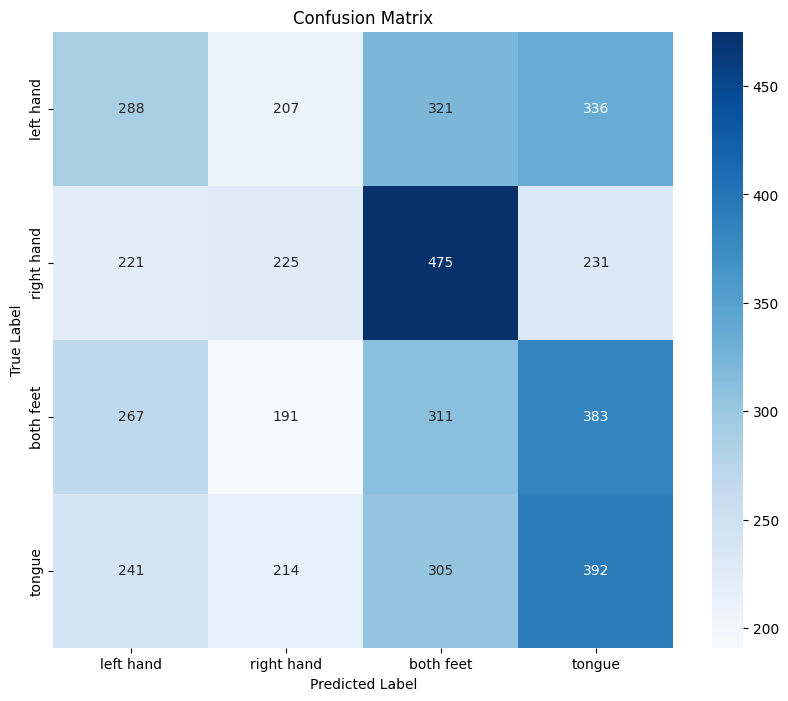

In [42]:
Confusion_s2 = np.zeros((4,4))
for i in list_arrays[8:16]:
    Confusion_s2 += i

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 8))

# Create the heatmap
sns.heatmap(Confusion_s2, annot=True, fmt='g', cmap='Blues', xticklabels=["left hand", "right hand", "both feet", "tongue"], yticklabels=["left hand", "right hand", "both feet", "tongue"])

# Add titles and labels
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Show the plot
plt.savefig('Confusion_S2.png', format='png')
plt.show()

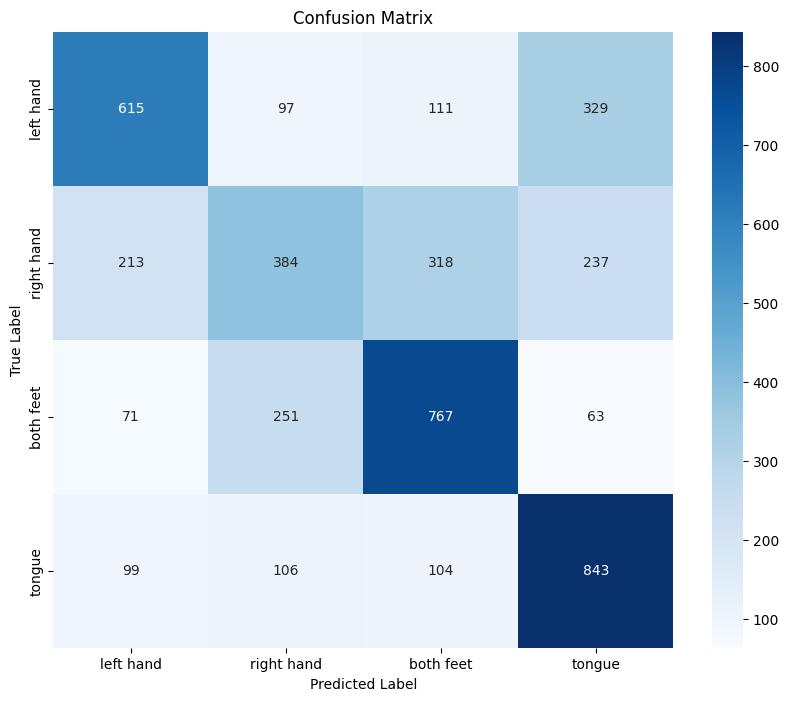

In [43]:
Confusion_s3 = np.zeros((4,4))
for i in list_arrays[16:24]:
    Confusion_s3 += i

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 8))

# Create the heatmap
sns.heatmap(Confusion_s3, annot=True, fmt='g', cmap='Blues', xticklabels=["left hand", "right hand", "both feet", "tongue"], yticklabels=["left hand", "right hand", "both feet", "tongue"])

# Add titles and labels
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('Confusion_S3.png', format='png')
# Show the plot
plt.show()

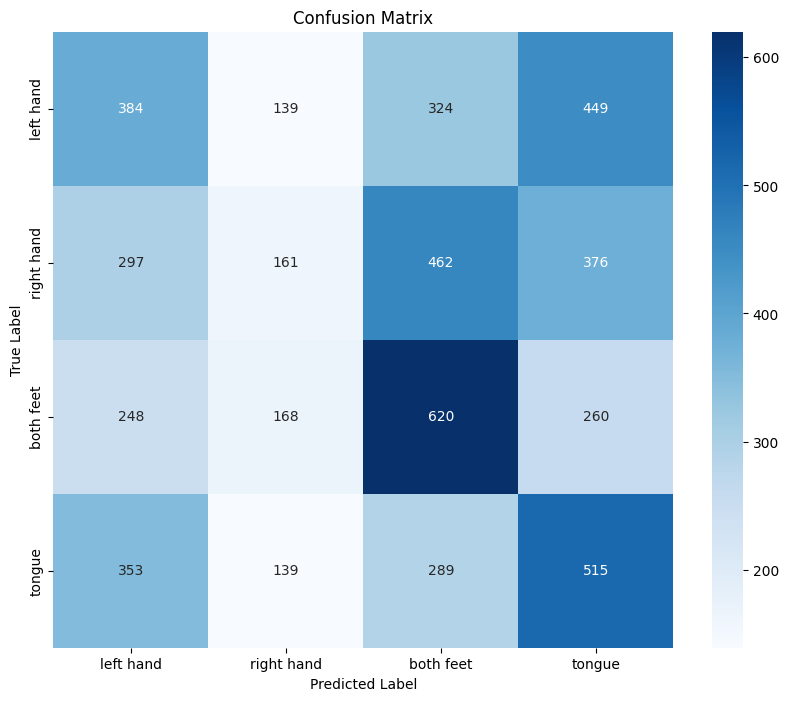

In [44]:
Confusion_LSTM = np.zeros((4,4))
for i in [0,8,16,24,32,40,48,56,64]:
    Confusion_LSTM += list_arrays[i]

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 8))

# Create the heatmap
sns.heatmap(Confusion_LSTM, annot=True, fmt='g', cmap='Blues', xticklabels=["left hand", "right hand", "both feet", "tongue"], yticklabels=["left hand", "right hand", "both feet", "tongue"])

# Add titles and labels
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('Confusion_LSTM.png', format='png')
# Show the plot
plt.show()

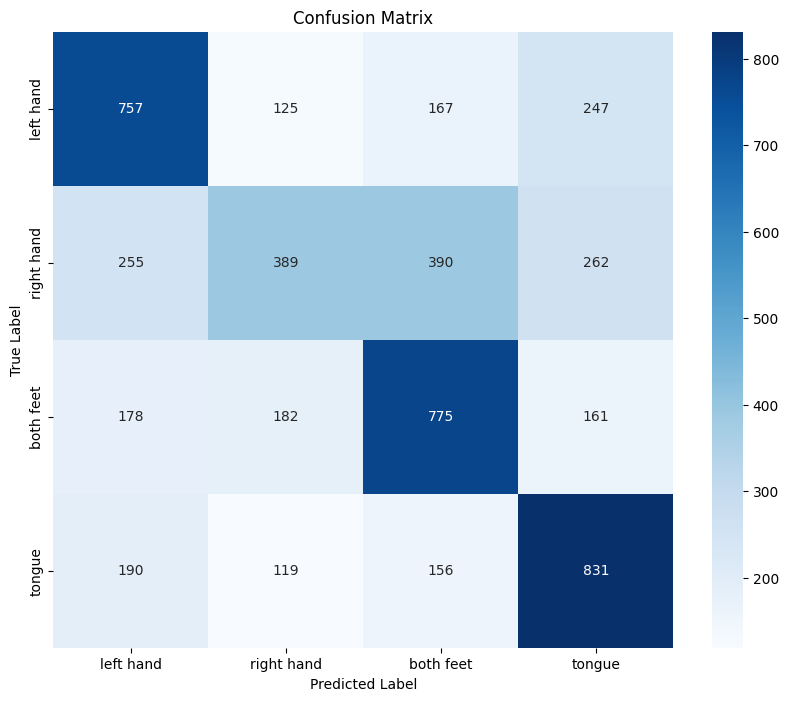

In [45]:
Confusion_NeX = np.zeros((4,4))
for i in [7,15,23,31,39,47,55,63,71]:
    Confusion_NeX += list_arrays[i]

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 8))

# Create the heatmap
sns.heatmap(Confusion_NeX, annot=True, fmt='g', cmap='Blues', xticklabels=["left hand", "right hand", "both feet", "tongue"], yticklabels=["left hand", "right hand", "both feet", "tongue"])

# Add titles and labels
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('Confusion_NeX.png', format='png')
# Show the plot
plt.show()